In [1]:
import cv2,os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  1
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# データの読み込み

In [3]:
Data_01=np.load("results2022/01x40_padded.npy",allow_pickle=True)
Data_02Nami=np.load("results2022/02x40_padded.npy",allow_pickle=True)

print("Data_01.shape:", Data_01.shape)
print("Data_02Nami.shape:", Data_02Nami.shape)

Data_01.shape: (65969, 100, 100, 3)
Data_02Nami.shape: (3219, 100, 100, 3)


In [4]:
DataPad_01=Data_01
DataPad_02Nami=Data_02Nami
# DataPad_01=Data_01[:len(Data_02Nami)]

print("Data_01.shape:", DataPad_01.shape)
print("Data_02Nami.shape:", DataPad_02Nami.shape)

Data_01.shape: (65969, 100, 100, 3)
Data_02Nami.shape: (3219, 100, 100, 3)


# データ処理

## 1. Padding Unify the size

In [5]:
# Max_shape_0 = 100
# Max_shape_1 = 100

In [6]:
# #　同じサイズにする 
# def datapadding(data):
#     DataPad=[]
#     for img in data:
#         imgSize = img.shape
#         top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
#         left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
#         if (imgSize[0] % 2) != 0:
#             top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
#         if (imgSize[1] % 2) != 0:     
#             left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
#         img_pad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
#         DataPad.append(img_pad)
#     return DataPad

# DataPad_01 = datapadding(Data_01)
# DataPad_02Nami = datapadding(Data_02Nami)
# print("DataPad_01: ",len(DataPad_01))
# print("DataPad_02Nami: ",len(DataPad_02Nami))

## 2. Resize by using Bin_ndarray

In [7]:
# DataBinResize = []
# def bin_ndarray(ndarray, new_shape, operation):
#     operation = operation.lower()
#     if not operation in ['sum', 'mean']:
#         raise ValueError("Operation not supported.")
#     if ndarray.ndim != len(new_shape):
#         raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
#                                                            new_shape))
#     compression_pairs = [(d, c//d) for d,c in zip(new_shape,
#                                                   ndarray.shape)]
#     flattened = [l for p in compression_pairs for l in p]
#     ndarray = ndarray.reshape(flattened)
#     for i in range(len(new_shape)):
#         op = getattr(ndarray, operation)
#         ndarray = op(-1*(i+1))
#     return ndarray

# for img in DataResize:
#     imgresize = bin_ndarray(img, new_shape=(512,512,3), operation='mean')
#     DataBinResize.append(imgresize)

In [8]:
# DataBinResize = np.array(DataBinResize)
# print("DataBinResize: ", DataBinResize.shape)

# img = cv2.imread(DataPath[1])
# print("DataPath[1].shape: ", img.shape)
# plt.imshow(img)
# plt.show()

# print("DataResize[1].shape: ", DataResize[1].shape)
# plt.imshow(DataResize[1])
# plt.show()

# print("DataBinResize[1].shape: ", DataBinResize[1].shape)
# plt.imshow(DataBinResize[1]/255)
# plt.show()

## 3. Split Train and Test

In [9]:
DataPad_01 = DataPad_01
DataLabel_01 = np.zeros(len(DataPad_01), dtype=np.int32)

DataPad_02Nami = DataPad_02Nami
DataLabel_02Nami = np.ones(len(DataPad_02Nami), dtype=np.int32)

In [10]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(DataPad_01, DataLabel_01, test_size=0.1, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(DataPad_02Nami, DataLabel_02Nami, test_size=0.1, random_state=42)

X_train, X_test = np.concatenate((X_train_0, X_train_1), axis = 0), np.concatenate((X_test_0, X_test_1), axis = 0)
y_train, y_test = np.concatenate((y_train_0, y_train_1), axis = 0), np.concatenate((y_test_0, y_test_1), axis = 0)

# データ前処理

In [11]:
class cell_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]), torch.tensor(self.y[idx], dtype=torch.long)

trainval_data = cell_dataset(X_train, y_train)

In [12]:
batch_size = 128

val_size = int(len(trainval_data)*0.2)
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [13]:
train_data_01 = 0
for i in range(train_size):
    train_data_01+=train_data[i][1].item()
print("Total number of train : ", train_size)
print("train_class_0: ", train_size-train_data_01)
print("train_class_1: ", train_data_01)

val_data_01 = 0
for i in range(val_size):
    val_data_01+=val_data[i][1].item()
print("\nTotal number of val : ", val_size)
print("val_class_0: ", val_size-val_data_01)
print("val_class_1: ", val_data_01)

print("\nTotal number of test : ", len(y_test))
print("test_class_0 num : ", y_test.tolist().count(0))
print("test_class_1 num : ", y_test.tolist().count(1))

Total number of train :  49816
train_class_0:  47520
train_class_1:  2296

Total number of val :  12453
val_class_0:  11852
val_class_1:  601

Total number of test :  6919
test_class_0 num :  6597
test_class_1 num :  322


# ResNet遷移学習

In [33]:
# model = torch.load("SelfResnet18_L2F1.pkl")

In [14]:
model = models.resnet18(pretrained=True)

model.layer3 = nn.Sequential()
model.layer4 = nn.Sequential()

model.fc = nn.Sequential(
    nn.Linear(128, 2),
#     nn.Softmax(dim=1)
)

# model.fc = nn.Sequential(
#     nn.Linear(512, 512),
#     # nn.Dropout(p=0.5),
#     nn.ReLU(inplace=True),
#     nn.Linear(512, 256),
#     nn.ReLU(inplace=True),
#     nn.Linear(256, 2)
# )

#Freeze model weights
for param in model.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [15]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_func = nn.NLLLoss()

# negative : ラベル0の数
# positive : ラベル1の数
# weight_for_0 : 1. / negative * (negative + positive)
# weight_for_1 : 1. / positive * (negative + positive)
# class_weight = {0 : weight_for_0, 1 : weight_for_1}
weights = torch.tensor([(len(DataPad_01)+len(DataPad_02Nami))/len(DataPad_01), 
                        (len(DataPad_01)+len(DataPad_02Nami))/len(DataPad_02Nami)]).cuda()
loss_function = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略


# model = model.cuda()
model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [16]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

In [17]:
n_epoches = 200
for epoch in range(n_epoches):
    losses_train = []
    losses_valid = []
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == y).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        y = y.to(device)
        output = model.forward(x)  # 順伝播
        loss = loss_function(output, y)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = output.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == y).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'
          .format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 0.491, Accuracy: 0.801], Valid [Loss: 0.958, Accuracy: 0.339]
EPOCH: 1, Train [Loss: 0.447, Accuracy: 0.828], Valid [Loss: 2.712, Accuracy: 0.952]
EPOCH: 2, Train [Loss: 0.428, Accuracy: 0.847], Valid [Loss: 1.821, Accuracy: 0.952]
EPOCH: 3, Train [Loss: 0.417, Accuracy: 0.852], Valid [Loss: 1.926, Accuracy: 0.222]
EPOCH: 4, Train [Loss: 0.411, Accuracy: 0.857], Valid [Loss: 2.689, Accuracy: 0.952]
EPOCH: 5, Train [Loss: 0.402, Accuracy: 0.860], Valid [Loss: 1.202, Accuracy: 0.353]
EPOCH: 6, Train [Loss: 0.391, Accuracy: 0.858], Valid [Loss: 0.377, Accuracy: 0.840]
EPOCH: 7, Train [Loss: 0.388, Accuracy: 0.859], Valid [Loss: 8.407, Accuracy: 0.952]
EPOCH: 8, Train [Loss: 0.388, Accuracy: 0.859], Valid [Loss: 4.011, Accuracy: 0.952]
EPOCH: 9, Train [Loss: 0.381, Accuracy: 0.858], Valid [Loss: 0.409, Accuracy: 0.894]
EPOCH: 10, Train [Loss: 0.375, Accuracy: 0.861], Valid [Loss: 0.838, Accuracy: 0.433]
EPOCH: 11, Train [Loss: 0.376, Accuracy: 0.857], Valid [Loss: 0.

EPOCH: 96, Train [Loss: 0.028, Accuracy: 0.989], Valid [Loss: 0.564, Accuracy: 0.875]
EPOCH: 97, Train [Loss: 0.035, Accuracy: 0.986], Valid [Loss: 1.003, Accuracy: 0.971]
EPOCH: 98, Train [Loss: 0.033, Accuracy: 0.987], Valid [Loss: 0.393, Accuracy: 0.966]
EPOCH: 99, Train [Loss: 0.032, Accuracy: 0.987], Valid [Loss: 0.368, Accuracy: 0.978]
EPOCH: 100, Train [Loss: 0.024, Accuracy: 0.991], Valid [Loss: 0.298, Accuracy: 0.971]
EPOCH: 101, Train [Loss: 0.047, Accuracy: 0.982], Valid [Loss: 1.016, Accuracy: 0.968]
EPOCH: 102, Train [Loss: 0.040, Accuracy: 0.984], Valid [Loss: 0.519, Accuracy: 0.983]
EPOCH: 103, Train [Loss: 0.016, Accuracy: 0.993], Valid [Loss: 0.430, Accuracy: 0.981]
EPOCH: 104, Train [Loss: 0.015, Accuracy: 0.994], Valid [Loss: 1.303, Accuracy: 0.978]
EPOCH: 105, Train [Loss: 0.045, Accuracy: 0.983], Valid [Loss: 0.361, Accuracy: 0.951]
EPOCH: 106, Train [Loss: 0.014, Accuracy: 0.995], Valid [Loss: 0.452, Accuracy: 0.981]
EPOCH: 107, Train [Loss: 0.024, Accuracy: 0.990

EPOCH: 191, Train [Loss: 0.002, Accuracy: 1.000], Valid [Loss: 0.785, Accuracy: 0.986]
EPOCH: 192, Train [Loss: 0.001, Accuracy: 1.000], Valid [Loss: 0.757, Accuracy: 0.987]
EPOCH: 193, Train [Loss: 0.009, Accuracy: 0.997], Valid [Loss: 0.407, Accuracy: 0.964]
EPOCH: 194, Train [Loss: 0.009, Accuracy: 0.996], Valid [Loss: 0.541, Accuracy: 0.981]
EPOCH: 195, Train [Loss: 0.001, Accuracy: 1.000], Valid [Loss: 0.561, Accuracy: 0.986]
EPOCH: 196, Train [Loss: 0.001, Accuracy: 1.000], Valid [Loss: 0.649, Accuracy: 0.988]
EPOCH: 197, Train [Loss: 0.002, Accuracy: 0.999], Valid [Loss: 0.706, Accuracy: 0.988]
EPOCH: 198, Train [Loss: 0.001, Accuracy: 1.000], Valid [Loss: 0.619, Accuracy: 0.988]
EPOCH: 199, Train [Loss: 0.001, Accuracy: 1.000], Valid [Loss: 0.696, Accuracy: 0.988]


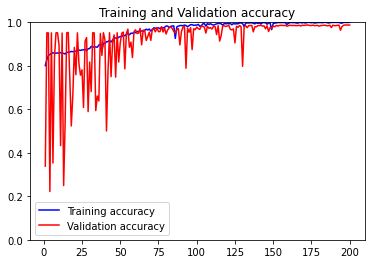

<Figure size 432x288 with 0 Axes>

In [19]:
# train processing plot
n_epoches = 200
epochs=range(1,n_epoches+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

# test with testdata

In [20]:
# Test
X = X_test
y = y_test
y_pred = []
out_pred = []
total = X.shape[0]

model.eval()
for n in range(total):
    img = X[n]
    label = y[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    output = model(input_tensor)
    pred = output.argmax(1).cpu().item()
    out_pred.append(output[0][1].item())
    y_pred.append(pred)

y_pred = np.array(y_pred)
out_pred = np.array(out_pred)
print("total_test: {:}" .format(total))
print('accuracy_score: {:.3f}'.format(accuracy_score(y,y_pred)))
print('precision_score: {:.3f}'.format(precision_score(y,y_pred)))
print('roc_auc_score: {:.3f}'.format(roc_auc_score(y, out_pred)))

total_test: 6919
accuracy_score: 0.987
precision_score: 0.869
roc_auc_score: 0.990


## test by category

In [212]:
def predict(model,input_tensor,true_y):
    model.eval()
    output = model(input_tensor)
    pre_y = output.argmax(1).cpu().item()
    return pre_y==true_y, pre_y

In [213]:
total = Data_01.shape[0]
count = 0
true_y = 0
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        count+=1
print("00 accuracy is ", count/total)
print("count/total is ", count,total)

/tmp/10323609.1.gpu/ipykernel_222014/2976431380.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm(range(total)):


  0%|          | 0/65969 [00:00<?, ?it/s]

00 accuracy is  0.9692128120784005
count/total is  63938 65969


In [214]:
total = Data_02Nami.shape[0]
count = 0
true_y = 1
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_02Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        count+=1
print("01 accuracy is ", count/total)
print("count/total is ", count,total)

/tmp/10323609.1.gpu/ipykernel_222014/1204296283.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm(range(total)):


  0%|          | 0/3219 [00:00<?, ?it/s]

01 accuracy is  0.9906803355079217
count/total is  3189 3219


# save model

In [21]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model,"SelfResnet18_L2F1_200.pkl")